In [ ]:
import json
import pandas as pd

with open('keyword_with_abstract.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
paper_df = pd.DataFrame(data)

In [2]:
paper_df[:5]

,paper_title,paper_author,publication,citied_by,cover_date,Abstract,affiliation_name,affiliation_city,affiliation_country
0,Real-Time Intelligent Anomaly Detection and Pr...,Gürfidan R.,Sakarya University Journal of Computer and Inf...,0,2023-12-31,Real-time anomaly detection in network traffic...,Isparta University of Applied Sciences,Isparta,Turkey
1,Prediction of Cardiovascular Disease Based on ...,Akkur E.,Sakarya University Journal of Computer and Inf...,0,2023-12-31,"Globally, cardiovascular diseases (CVD) accoun...",Turkish Medicines and Medical Devices Agency,Cankaya,Turkey
2,Social Media User Opinion Analysis Using Deep ...,Şencan Ö.A.,Turkish Journal of Mathematics and Computer Sc...,0,2023-12-31,The rapid surge in social media usage has augm...,Gazi Üniversitesi,Ankara,Turkey
3,Skin Lesion Classification Using Convolutional...,Kestek E.,Turkish Journal of Mathematics and Computer Sc...,1,2023-12-31,"Skin cancer, which can occur in any part of th...",Bartin Üniversitesi,Bartin,Turkey
4,Artificial intelligence (AI) or augmented inte...,Moodley K.,South African medical journal = Suid-Afrikaans...,2,2023-12-31,The sanctity of the doctor-patient relationshi...,"Stellenbosch University, Faculty of Medicine a...",Cape Town,South Africa


In [3]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer

# 假设 paper_df 包含 'paper_title' 和 'paper_author' 列
# 预处理函数，去掉无用字符
def remove(word_lst):
    remove_char = "(!.,'\"?:-/%ω)`~^$#@′√“‘”"
    for i in range(len(word_lst)):
        word = word_lst[i]
        for char in word:
            if char in remove_char:
                word = word.replace(char, '')
        word_lst[i] = word
    return word_lst

# 预处理标题
def preprocess_title(title):
    title = title.lower()  # 转小写
    title = re.sub(r'\d+', '', title)  # 去除所有数字
    words = title.split()  # 分词
    words = remove(words)  # 去除特殊字符
    return ' '.join(words)  # 重新组合成字符串

# 处理文章-词频矩阵
paper_df["cleaned_title"] = paper_df["paper_title"].astype(str).apply(preprocess_title)
vectorizer = CountVectorizer(ngram_range=(1, 3))
X = vectorizer.fit_transform(paper_df["cleaned_title"])
word_freq_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# 处理文章-作者矩阵
author_matrix = pd.get_dummies(paper_df["paper_author"]).astype(int)

# 合并文章-作者矩阵和文章-词频矩阵
final_matrix = pd.concat([author_matrix, word_freq_df], axis=1)

# 结果
if "NA" in final_matrix.columns:
    final_matrix = final_matrix.drop(columns=["NA"])

In [4]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

paper_df["log_cited_by"] = np.log1p(paper_df["citied_by"].astype(int))

X = final_matrix  # 文章-作者 + 文章-词频 矩阵
y = paper_df["log_cited_by"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.01, max_iter=1000)  # 设定一个合适的 alpha
lasso.fit(X_scaled, y)

coef_series = pd.Series(lasso.coef_, index=X.columns)
non_zero_coefs = coef_series[coef_series != 0].abs().sort_values(ascending=False)
top_30_features = non_zero_coefs.head(30)
print("最重要的 30 个特征:")
print(top_30_features)


最重要的 30 个特征:
survey                 0.152364
Buttazzo G.            0.150999
Ji Z.                  0.150289
Buller R.              0.102137
recent                 0.098742
diagnosis              0.096071
classification         0.085511
Fu L.                  0.082070
Idrissi M.J.           0.081063
Rathi N.               0.078119
intention              0.077066
international          0.074014
review of              0.072377
Zhuo F.                0.072286
Menghani G.            0.070087
an artificial          0.069280
transportation         0.068911
interpretable          0.068706
and                    0.066627
ensemble machine       0.065587
quantification         0.064683
Nauta M.               0.064184
lithiumion             0.064126
issues                 0.063933
Breit A.               0.063172
flexible               0.063157
intelligent systems    0.061249
Yan X.                 0.061193
for realtime           0.059014
drug                   0.058304
dtype: float64


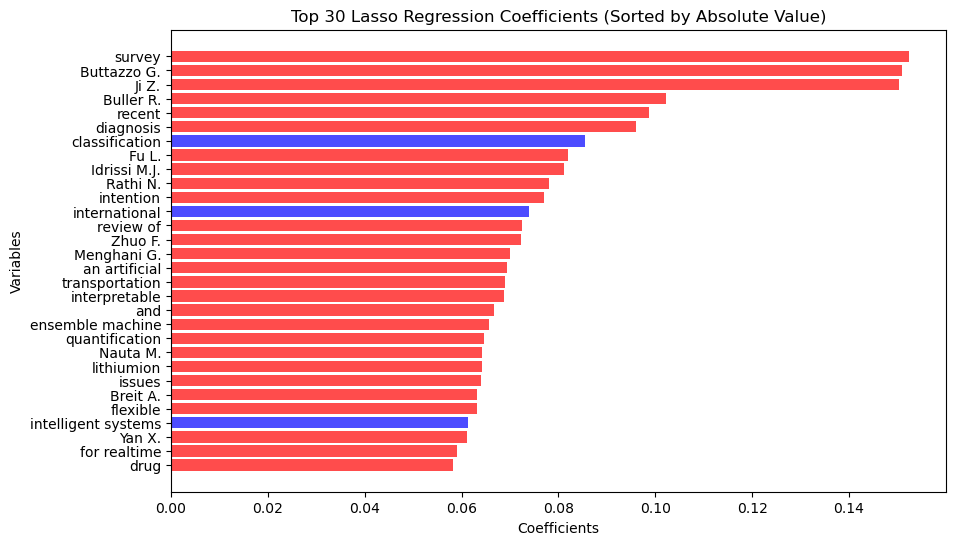

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Get the top 30 features and their coefficients
non_zero_coefs = coef_series[coef_series != 0].abs().sort_values(ascending=False)
top_30_features = non_zero_coefs.head(30)

# Sort the features by the absolute value of the coefficients, maintaining the sign
top_30_features = top_30_features.sort_values(ascending=True)

# Create a color map based on the sign of the coefficients with better color handling
colors = ['red' if coef_series[feature] > 0 else 'blue' for feature in top_30_features.index]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(top_30_features.index, top_30_features.values, color=colors, alpha=0.7)

# Adding title and labels
plt.xlabel("Coefficients")
plt.ylabel("Variables")
plt.title("Top 30 Lasso Regression Coefficients (Sorted by Absolute Value)")

# Show the plot
plt.show()


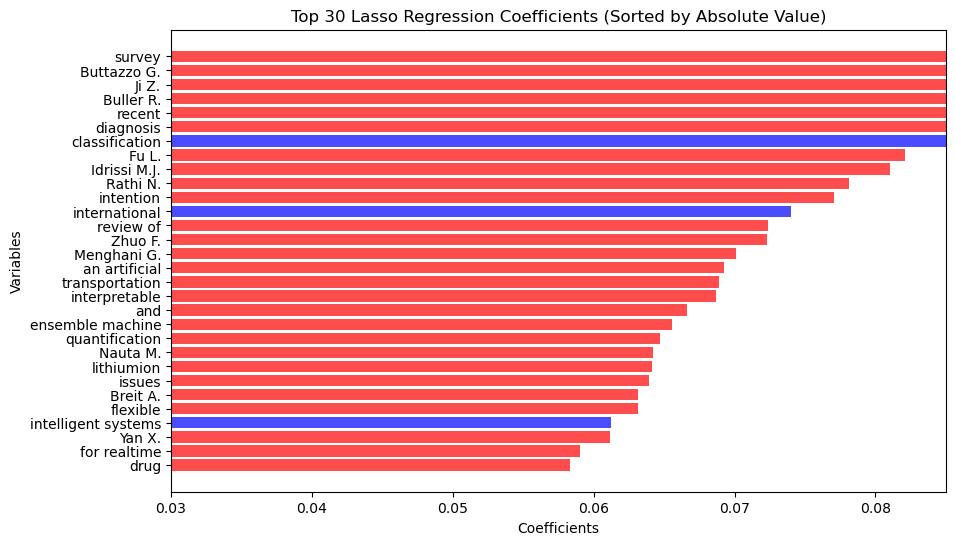

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Get the top 30 features and their coefficients
non_zero_coefs = coef_series[coef_series != 0].abs().sort_values(ascending=False)
top_30_features = non_zero_coefs.head(30)

# Sort the features by the absolute value of the coefficients, maintaining the sign
top_30_features = top_30_features.sort_values(ascending=True)

# Create a color map based on the sign of the coefficients
colors = ['red' if coef_series[feature] > 0 else 'blue' for feature in top_30_features.index]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(top_30_features.index, top_30_features.values, color=colors, alpha=0.7)

# Add title and labels
plt.xlabel("Coefficients")
plt.ylabel("Variables")
plt.title("Top 30 Lasso Regression Coefficients (Sorted by Absolute Value)")

# Set x-axis limits for better control over the range
plt.xlim(0.03, 0.085)

# Show the plot
plt.show()


在学术出版领域，带有“editorial”标签的文章（如社论、编辑评论等）通常会被认为与原创研究工作有所不同。以下是一些可能的原因，解释为什么带有“editorial”标签的文章可能会降低被引用次数：

非原创性内容：社论类文章通常是对已有研究的评论、总结或观点表达，而非基于新实验、数据或理论的原创性研究。因此，研究人员可能会倾向于引用具有新发现或方法的研究文章，而非评论性文章。

影响力有限：社论通常集中于某一特定领域的评论或讨论，面向的读者群体可能相对较小，且主要是对该主题感兴趣的学者、研究人员和政策制定者。因此，其在更广泛的学术领域中被引用的可能性较低。

带有“review”标签的文章通常会比其他类型的文章（如原始研究文章或社论）获得更多的引用，主要有以下几个原因：

广泛的覆盖范围：综述文章通常总结和分析某一特定领域的大量研究成果，提供对该领域的全面回顾。这使得它们成为其他研究人员了解领域现状、理论进展和未来研究方向的关键资源。因此，综述文章能够覆盖广泛的研究主题，吸引更多的读者和引用。

学术资源的聚合：综述文章为研究人员提供了一个关于特定主题的综合视角，帮助他们快速了解已有的研究成果和主要观点。这对于其他研究人员来说是非常有用的，尤其是在他们需要为自己的研究工作提供背景或参考文献时。引用这些综述文章是一个方便的方式，因为它们总结了大量的原始研究